In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from load_graph_nmr_chpeaks import graph_nmr_data_2d_peak, custom_collate_fn

from Comenet_NMR_multitask import ComENet
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.cuda.amp import autocast, GradScaler
import time
import matplotlib.pyplot as plt
import numpy as np
import pickle
import argparse
import os

/work/yunruili/anaconda_env/diffusion/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.16) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/work/yunruili/anaconda_env/diffusion/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
nmr_path = '/scratch0/yunruili/2dnmr_30k/nmr_2dcsv_chmatched/' #nmr_2dcsv_expanded
graph_path = '/scratch0/yunruili/2dnmr_30k/graph_3d/'
csv_file = 'nmr_smile_solvent_filtered2_3dgnn.csv'

# Set a seed for reproducibility
torch.manual_seed(0)

dataset = graph_nmr_data_2d_peak(csv_file, graph_path, nmr_path)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=1, collate_fn=custom_collate_fn)
val_dataloader = DataLoader(val_dataset, shuffle=True, batch_size=1, collate_fn=custom_collate_fn)

dataloaders = {'train': train_dataloader, 'val': val_dataloader}


In [5]:
hc = 256
chc=[128]
hhc=[128, 64, 64]
n = 3
n_out = 2
model = ComENet(in_embed_size=3, c_out_channels=1, h_out_channels=2, agg_method='sum',\
     hidden_channels=hc, c_out_hidden=chc, h_out_hidden=hhc, num_layers=n, num_output_layers=n_out)
msg = model.load_state_dict(torch.load(
    'gnn3d_2dch_sum_hiddendim_%d_nlayers_%d_noutlayers_%d_couthidden_%s_houthidden_%s.pt'\
    %(hc, n, n_out, ''.join(str(i) for i in chc), ''.join(str(i) for i in hhc)), map_location='cpu'))
print(msg)

<All keys matched successfully>


In [6]:
import torch.nn.functional as F
# loss = []
for i, data in enumerate(train_dataloader):
    graph, cnmr, hnmr, filename = data
    
    c_nodes = (graph.x[:,0]==5).nonzero(as_tuple=True)[0]
    h_nodes = (graph.x[:, 0] == 0).nonzero(as_tuple=True)[0] 

    c_shifts, h_shifts = model(graph)

    ##### calculate the indices of C node connected to H
    # Initialize a list to store C nodes connected to H
    c_nodes_connected_to_h = []
    # Check each C node for connection to any H node
    for c_node in c_nodes:
        # Get indices of edges involving the C node
        edges_of_c = (graph.edge_index[0] == c_node) | (graph.edge_index[1] == c_node)

        # Get all nodes that are connected to this C node
        connected_nodes = torch.cat((graph.edge_index[0][edges_of_c], graph.edge_index[1][edges_of_c])).unique()

        # Check if any of these connected nodes are H nodes
        if any(node in h_nodes for node in connected_nodes):
            c_nodes_connected_to_h.append(c_node.item())
    
    # Convert to a tensor
    c_nodes_connected_to_h = torch.tensor(c_nodes_connected_to_h)

    

    # c_shifts = c_shifts.flatten().detach().numpy()
    # h_shifts = h_shifts.flatten().detach().numpy()
    # cnmr = cnmr.squeeze().detach().numpy()
    # hnmr = hnmr.squeeze().detach().numpy()

    c_index = [i for i, x in enumerate(c_nodes) if x in c_nodes_connected_to_h]
    c_shifts = c_shifts[c_index]

    # print(c_shifts.shape)
    # print(cnmr.shape)
    # print(h_shifts.shape)
    # print(hnmr.shape)

    closs = F.l1_loss(c_shifts, cnmr).item() * 200
    hloss = F.l1_loss(h_shifts, hnmr).item() * 10

    # loss.append([closs, hloss])
    break


In [7]:
loss

NameError: name 'loss' is not defined

In [ ]:
# loss = np.array(loss)
avg_loss = np.mean(loss, axis=0)
avg_loss

array([4.88485081, 0.34091718])

In [ ]:
np.savetxt('loss_c128h1286464.csv', loss, delimiter=',')

In [8]:
hnmr = hnmr.detach().numpy() 
cnmr = cnmr.detach().numpy() 
h_shifts = h_shifts.detach().numpy() 
c_shifts = c_shifts.detach().numpy() 

cnmr = cnmr.flatten() * 200
hnmr = hnmr.flatten() * 10
h_shifts = h_shifts.flatten() * 10
c_shifts = c_shifts.flatten() * 200

('02162',)


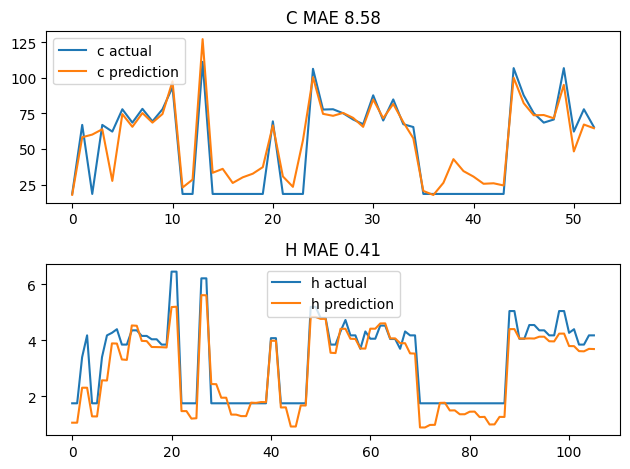

In [9]:
# visualize
import numpy as np
import matplotlib.pyplot as plt

print(filename)
plt.figure()
plt.subplot(211)
plt.plot(np.arange(len(cnmr)), cnmr, label='c actual')
plt.plot(np.arange(len(c_shifts)), c_shifts, label='c prediction')
# error = np.sqrt(np.mean(c_shifts - cnmr)**2)
error = np.mean(np.abs(c_shifts - cnmr))
plt.title('C MAE %0.2f'%error)
plt.legend()
plt.subplot(212)
plt.plot(np.arange(len(hnmr)), hnmr, label='h actual')
plt.plot(np.arange(len(h_shifts)), h_shifts, label='h prediction')
# error = np.sqrt(np.mean(h_shifts - hnmr)**2)
error = np.mean(np.abs(h_shifts - hnmr))
plt.title('H MAE %0.2f'%error)
plt.legend()
plt.tight_layout()

In [ ]:
filename

NameError: name 'filename' is not defined